In [3]:
import stan
import pandas as pd
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nest_asyncio.apply()

In [267]:
schools_code = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
  vector[T] D_heat;

  vector[T] M;
}

parameters {
  real mu;
  real psi;
  real psi_2;

  real d_sat;
  real d_sun;
  real d_mon;
  real d_heat;


  vector[T] epsilon_1;
  vector[T] epsilon_2;

  real<lower=0> eta_u;
  real<lower=0> eta_d;

  real kappa_hs;
  real<lower=0> omega_h;
  real<lower=-1,upper=1> phi_h;
  real theta_h;

  array[T] simplex[3] q;

  vector[T] J_s;
  vector[T] h_s;
}
transformed parameters { 
  vector[T] J = J_s;
  vector[T] h = h_s;
  vector<lower=0>[T] xi_d;
  vector<lower=0>[T] xi_u;
  vector[T] y_fit;
  real kappa_h;

  if (kappa_hs > 2) {
    kappa_h = 0;
  }
  else if (kappa_hs < 0) {
    kappa_h = 0;
  }
  else {
    kappa_h = kappa_hs;
  }

  for (t in 1:T) {
    xi_d[t] = exp(eta_d);
    xi_u[t] = exp(eta_u);
  }

  for (t in 1:T) {
    J[t] = -xi_d[t] * q[t][1] + 0 * q[t][2] + xi_u[t] * q[t][3];
  }

  h[1] = 0;
  for (t in 2:T) {
    h[t] = h[t-1] + kappa_h * (theta_h - h[t-1]) + phi_h * epsilon_1[t] + sqrt(omega_h) * epsilon_2[t];
  }

  for (t in 2:800) {
    y_fit[t] = y[t] - y[t-1] - mu - psi * X[t] - J[t] - d_sat * D_sat[t] - d_sun * D_sun[t] - d_mon * D_mon[t] - d_heat * D_heat[t] - psi_2 * M[t-1];
    // - psi_3 * X[t-1]
    // - psi_2 * M[t-1]
    // - d_heat * D_heat[t]
    // - d_hol * D_hol[t]
  }
}
model {
  // Prior
  mu ~ normal(0, 10);
  psi ~ normal(0, 10);
  psi_2 ~ normal(0, 10);

  d_sat ~ normal(0, 10);
  d_sun ~ normal(0, 10);
  d_mon ~ normal(0, 10);
  d_heat ~ normal(0, 10);

  kappa_hs ~ normal(1, 6);

  omega_h ~ inv_gamma(3, 0.05);
  phi_h ~ normal(0, 0.5 * omega_h);
  theta_h ~ normal(0, 10);

  eta_u ~ inv_gamma(1.86, 0.43);
  eta_d ~ inv_gamma(1.86, 0.43);

  //alpha = rep_vector(1, 3);
  for (t in 1:T) {
    q[t] ~ dirichlet(rep_vector(1, 3));
  }

  for (t in 1:T) {
    epsilon_1[t] ~ normal(0, 1);
    epsilon_2[t] ~ normal(0, 1);
  }

  for (t in 2:800) {
    y_fit[t] ~ normal(0, exp(h[t] / 2));
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 800:T) {
    y_rep[t] = y[t-1] + mu + psi * X[t] + J[t] + d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t] + epsilon_1[t] * sqrt(exp(h[t-1])) + d_heat * D_heat[t] + psi_2 * M[t-1];
    // + psi_3 * X[t-1]
    // + psi_2 * M[t-1]
    // + d_heat * D_heat[t]
    // + d_hol * D_hol[t]
  }
}
"""

In [268]:
def generate_results(zone, hour):
    data = { 
        "T": 1000,
        "y": np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/prices_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv')['prices']).to_numpy()[552:],
        "X": np.squeeze(np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/temperature_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv', usecols=['temp']).to_numpy()))[552:],

        "M": np.squeeze(np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/temperature/min_zone{zone}.csv', usecols=['temp']).to_numpy()))[552:],
        "D_heat": np.squeeze(pd.read_csv(f'/home/tim/dv/bsv_inference/data/df_heat.csv', usecols=['heating']).astype(int).to_numpy())[552:],

        "D_sun": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/sundays.csv').to_numpy())[552:],
        "D_sat": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/saturdays.csv').to_numpy())[552:],
        "D_mon": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/mondays.csv').to_numpy())[552:]
        }

    posterior = stan.build(schools_code, data=data)
    fit = posterior.sample(num_chains=4)
    df = fit.to_frame()
    df.to_csv(f'~/dv/bsv_inference/results/zone_{zone}/zone_{zone}_hour_{hour}_aug.csv', index=False)
    return

In [269]:
for hour in range(6, 24):
    generate_results(zone=2, hour=hour)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)Future e

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 96, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 54, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_xqu5vq37/model_2wgrhmy2.stan', line 51, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

In [53]:
raw_model = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real mu;
  real psi;

  real d_sat;
  real d_sun;
  real d_mon;

  vector[T] epsilon_1;
  vector[T] epsilon_2;

  real<lower=0> eta_u;
  real<lower=0> eta_d;

  real kappa_hs;
  real<lower=0> omega_h;
  real<lower=-1,upper=1> phi_h;
  real theta_h;

  array[T] simplex[3] q;

  vector[T] J_s;
  vector[T] h_s;
}
transformed parameters { 
  vector[T] J = J_s;
  vector[T] h = h_s;
  vector<lower=0>[T] xi_d;
  vector<lower=0>[T] xi_u;
  vector[T] y_fit;
  real kappa_h;

  if (kappa_hs > 2) {
    kappa_h = 0;
  }
  else if (kappa_hs < 0) {
    kappa_h = 0;
  }
  else {
    kappa_h = kappa_hs;
  }

  for (t in 1:T) {
    xi_d[t] = exp(eta_d);
    xi_u[t] = exp(eta_u);
  }

  for (t in 1:T) {
    J[t] = -xi_d[t] * q[t][1] + 0 * q[t][2] + xi_u[t] * q[t][3];
  }

  h[1] = 0;
  for (t in 2:T) {
    h[t] = h[t-1] + kappa_h * (theta_h - h[t-1]) + phi_h * epsilon_1[t] + sqrt(omega_h) * epsilon_2[t];
  }

  for (t in 2:800) {
    y_fit[t] = y[t] - y[t-1] - mu - psi * X[t] - J[t] - d_sat * D_sat[t] - d_sun * D_sun[t] - d_mon * D_mon[t];
    // - psi_3 * X[t-1]
    // - psi_2 * M[t-1]
    // - d_heat * D_heat[t]
    // - d_hol * D_hol[t]
  }
}
model {
  // Prior
  mu ~ normal(0, 10);
  psi ~ normal(0, 10);

  d_sat ~ normal(0, 10);
  d_sun ~ normal(0, 10);
  d_mon ~ normal(0, 10);

  kappa_hs ~ normal(1, 6);

  omega_h ~ inv_gamma(3, 0.05);
  phi_h ~ normal(0, 0.5 * omega_h);
  theta_h ~ normal(0, 10);

  eta_u ~ inv_gamma(1.86, 0.43);
  eta_d ~ inv_gamma(1.86, 0.43);

  //alpha = rep_vector(1, 3);
  for (t in 1:T) {
    q[t] ~ dirichlet(rep_vector(1, 3));
  }

  for (t in 1:T) {
    epsilon_1[t] ~ normal(0, 1);
    epsilon_2[t] ~ normal(0, 1);
  }

  for (t in 2:800) {
    y_fit[t] ~ normal(0, exp(h[t] / 2));
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 800:T) {
    y_rep[t] = y[t-1] + mu + psi * X[t] + J[t] + d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t] + epsilon_1[t] * sqrt(exp(h[t-1]));
    // + psi_3 * X[t-1]
    // + psi_2 * M[t-1]
    // + d_heat * D_heat[t]
    // + d_hol * D_hol[t]
  }
}
"""

In [54]:
def generate_results_raw(zone, hour):
    data = { 
        "T": 1000,
        "y": np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/prices_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv')['prices']).to_numpy()[552:],
        "X": np.squeeze(np.log(pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/temperature_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv', usecols=['temp']).to_numpy()))[552:],

        "D_sun": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/sundays.csv').to_numpy())[552:],
        "D_sat": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/saturdays.csv').to_numpy())[552:],
        "D_mon": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/mondays.csv').to_numpy())[552:]
        }

    posterior = stan.build(raw_model, data=data)
    fit = posterior.sample(num_chains=4)
    df = fit.to_frame()
    df.to_csv(f'~/dv/bsv_inference/results/zone_{zone}/zone_{zone}_hour_{hour}.csv', index=False)
    return

In [55]:
for hour in range(13, 24):
    generate_results_raw(zone=2, hour=hour)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 88, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan__7j2el16/model_nvqvo3c5.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Samplin

In [258]:
def read_preds(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}/zone_{zone}_hour_{hour}.csv')
    return df

count    4000.000000
mean        6.818791
std         0.393176
min         3.757105
5%          6.166566
25%         6.561539
50%         6.810128
75%         7.073670
95%         7.475066
max         9.154280
Name: y_rep.850, dtype: float64

In [99]:
# Define initial date
initial_date = '2023-09-13'
df = pd.read_csv('/home/tim/dv/bsv_inference/results/zone_2/zone_2_hour_13.csv')
# Define number of days
num_days = 200
log_prices_arr = []
for i in range(800, 1000):
    tf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%']
    sf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%']
    no_outliers = [n for n in df[f'y_rep.{i}'].to_numpy() if (tf < n < sf)]

    log_prices_arr.append(np.median(no_outliers))

log_prices_arr = np.array(log_prices_arr)

prices = np.exp(log_prices_arr)
# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)
print(date_range.shape)
print(log_prices_arr.shape)
# Create a DataFrame with datetime and corresponding values
res_df = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr), 'Prices': np.array(prices)})
res_df['LogDiff'] = np.log(res_df['Prices']).diff()

fq = []
tq = []
ff = []
lf = []
for i in range(800, 1000):
    fq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%'])
    tq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%'])
    ff.append(df[f'y_rep.{i}'].describe(percentiles=[0.05, 0.25, 0.5, 0.75])['5%'])
    lf.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])['95%'])

res_df['first_quartile'] = fq
res_df['third_quartile'] = tq
res_df['five_pc'] = ff
res_df['nintetyfive_pc'] = lf
print(res_df)

(200,)
(200,)
      Datetime  LogPrices       Prices   LogDiff  first_quartile  \
0   2023-09-13   6.691268   805.342664       NaN        6.684981   
1   2023-09-14   6.701531   813.650218  0.010263        6.442071   
2   2023-09-15   7.055883  1159.660464  0.354352        6.787788   
3   2023-09-16   7.110320  1224.539735  0.054438        6.767178   
4   2023-09-17   6.935749  1028.389634 -0.174571        6.648137   
..         ...        ...          ...       ...             ...   
195 2024-03-26   7.200577  1340.204118 -0.027677        6.869548   
196 2024-03-27   7.143189  1265.456982 -0.057389        6.854604   
197 2024-03-28   7.208868  1351.362095  0.065680        6.848220   
198 2024-03-29   7.042953  1144.763538 -0.165915        6.737854   
199 2024-03-30   7.263055  1426.608654  0.220102        6.903245   

     third_quartile   five_pc  nintetyfive_pc  
0          6.698317  6.657191        6.721775  
1          6.997161  5.985318        7.316612  
2          7.369932  6.30

In [77]:
res_df['Prices'].describe(percentiles=[0.25, 0.5, 0.75])

count     200.000000
mean     1136.669270
std       283.750673
min       495.032768
25%       933.317634
50%      1128.065617
75%      1320.256196
max      2081.293625
Name: Prices, dtype: float64

In [15]:
import matplotlib.pyplot as plt
def plot_ts(dataframe, col):
    # Plot the time series data
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe['Datetime'], dataframe[col], linestyle='-', color='black', linewidth = 0.5)
    # plt.axvline(x=pd.to_datetime('2023-08-24'), color='red', linestyle='--', label='Vertical Line')
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

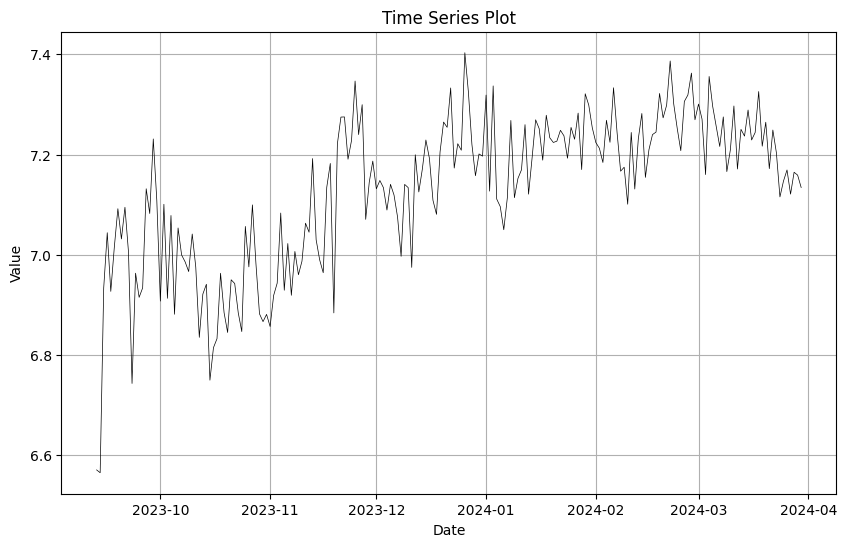

In [16]:
plot_ts(res_df, 'LogPrices')

In [80]:
res_df['first_quartile']

0      6.374702
1      5.722957
2      6.511368
3      6.769482
4      6.615738
         ...   
195    6.668047
196    6.820994
197    6.467598
198    6.951606
199    6.753611
Name: first_quartile, Length: 200, dtype: float64

In [98]:
fact = pd.read_csv('/home/tim/dv/bsv_inference/data_raw/prices_raw/zone_2/zone_2_hour_13.csv')[1352:]

In [82]:
fact

,dates,prices
1352,2023-09-14,1001.04
1353,2023-09-15,1067.27
1354,2023-09-16,995.50
1355,2023-09-17,1051.89
1356,2023-09-18,1093.83
...,...,...
1547,2024-03-27,1090.99
1548,2024-03-28,1120.11
1549,2024-03-29,1167.29
1550,2024-03-30,1325.58


In [83]:
res_df

,Datetime,LogPrices,Prices,LogDiff,first_quartile,third_quartile,five_pc,nintetyfive_pc
0,2023-09-13,6.380346,590.132004,NaN,6.374702,6.383723,6.317490,6.429310
1,2023-09-14,6.271785,529.421394,-0.108562,5.722957,6.335354,5.488090,6.833735
2,2023-09-15,7.097645,1209.115937,0.825860,6.511368,7.417487,6.235985,7.711813
3,2023-09-16,7.010137,1107.806538,-0.087507,6.769482,7.506998,6.357142,7.666452
4,2023-09-17,6.901563,993.826778,-0.108574,6.615738,7.047771,6.386727,7.540557
...,...,...,...,...,...,...,...,...
195,2024-03-26,6.803299,900.813830,-0.279264,6.668047,7.235552,2.902742,7.627806
196,2024-03-27,7.119415,1235.726734,0.316116,6.820994,7.575284,6.586126,9.513356
197,2024-03-28,6.756185,859.357912,-0.363229,6.467598,7.158382,5.916973,7.606711
198,2024-03-29,7.206573,1348.263483,0.450387,6.951606,7.730466,6.410185,13.101280


In [84]:
res_df['Prices']

0       590.132004
1       529.421394
2      1209.115937
3      1107.806538
4       993.826778
          ...     
195     900.813830
196    1235.726734
197     859.357912
198    1348.263483
199    1422.461917
Name: Prices, Length: 200, dtype: float64

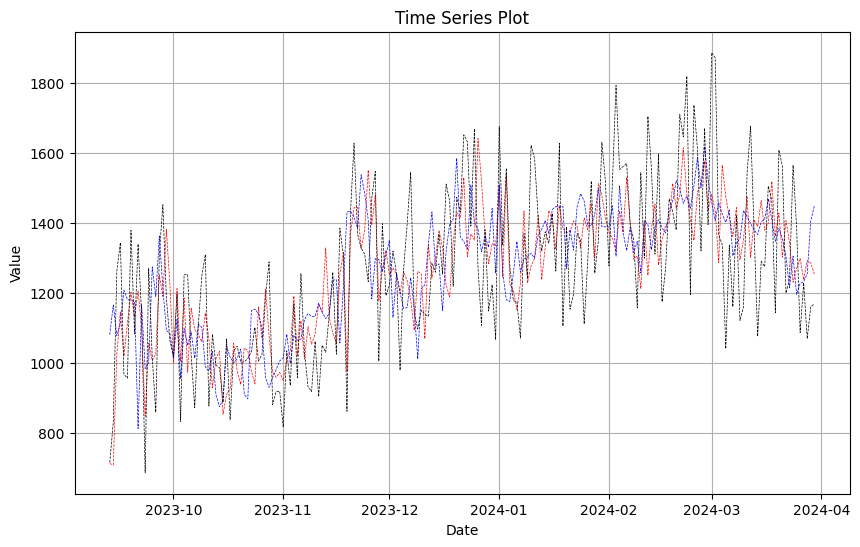

In [21]:
plt.figure(figsize=(10, 6))
# plt.plot(res_df['Datetime'], res_df['Prices'], linestyle='-', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['five_pc']), linestyle=':', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['nintetyfive_pc']), linestyle=':', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['first_quartile']), linestyle='--', color='black', linewidth = 0.5)
# plt.plot(res_df['Datetime'], np.exp(res_df['third_quartile']), linestyle='--', color='black', linewidth = 0.5)
plt.plot(res_df['Datetime'], res_df['Prices'], linestyle='--', color='red', linewidth = 0.5)
plt.plot(res_df['Datetime'], fact['prices'], linestyle='--', color='blue', linewidth = 0.5)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

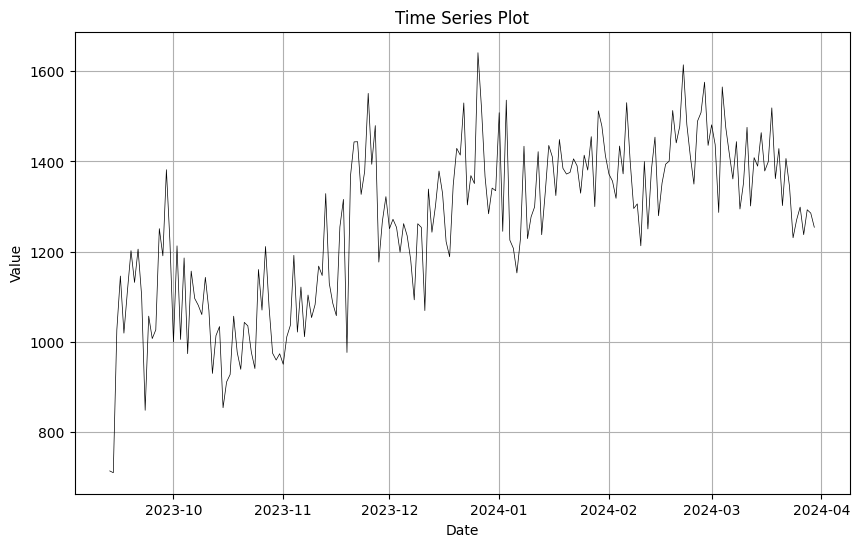

In [23]:
plot_ts(res_df, 'Prices')

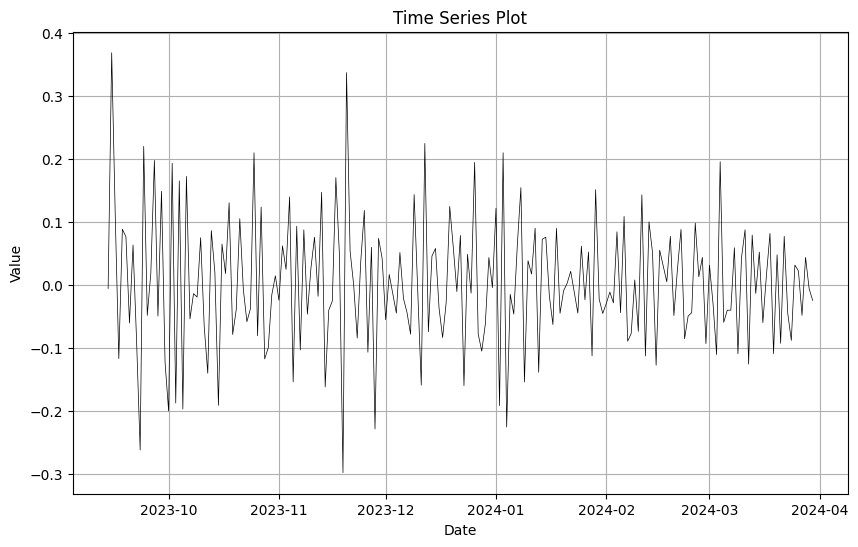

In [17]:
plot_ts(res_df, 'LogDiff')

In [2]:
res_df.shape
df = pd.read_csv('/home/tim/dv/bsv_inference/results/zone_2/zone_2_hour_13_aug.csv')
# Define initial date
initial_date = '2023-09-13'
# Define number of days
num_days = 200
log_prices_arr = []
for i in range(800, 1000):
    tf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%']
    sf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%']
    no_outliers = [n for n in df[f'y_rep.{i}'].to_numpy() if (tf < n < sf)]

    log_prices_arr.append(np.median(no_outliers))

log_prices_arr = np.array(log_prices_arr)

prices = np.exp(log_prices_arr)
# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)
print(date_range.shape)
print(log_prices_arr.shape)
# Create a DataFrame with datetime and corresponding values
res_df1 = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr), 'Prices': np.array(prices)})
res_df1['LogDiff'] = np.log(res_df1['Prices']).diff()

fq = []
tq = []
ff = []
lf = []
for i in range(800, 1000):
    fq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%'])
    tq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%'])
    ff.append(df[f'y_rep.{i}'].describe(percentiles=[0.05, 0.25, 0.5, 0.75])['5%'])
    lf.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])['95%'])

res_df1['first_quartile'] = fq
res_df1['third_quartile'] = tq
res_df1['five_pc'] = ff
res_df1['nintetyfive_pc'] = lf
print(res_df1)

NameError: name 'pd' is not defined

In [220]:
res_df.shape
df = pd.read_csv('/home/tim/dv/bsv_inference/results/zone_2/zone_2_hour_1_aug2.csv')
# Define initial date
initial_date = '2023-09-13'
# Define number of days
num_days = 200
log_prices_arr = []
for i in range(800, 1000):
    tf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%']
    sf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%']
    no_outliers = [n for n in df[f'y_rep.{i}'].to_numpy() if (tf < n < sf)]

    log_prices_arr.append(np.median(no_outliers))

log_prices_arr = np.array(log_prices_arr)

prices = np.exp(log_prices_arr)
# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)
print(date_range.shape)
print(log_prices_arr.shape)
# Create a DataFrame with datetime and corresponding values
res_df2 = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr), 'Prices': np.array(prices)})
res_df2['LogDiff'] = np.log(res_df2['Prices']).diff()

fq = []
tq = []
ff = []
lf = []
for i in range(800, 1000):
    fq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%'])
    tq.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%'])
    ff.append(df[f'y_rep.{i}'].describe(percentiles=[0.05, 0.25, 0.5, 0.75])['5%'])
    lf.append(df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])['95%'])

res_df2['first_quartile'] = fq
res_df2['third_quartile'] = tq
res_df2['five_pc'] = ff
res_df2['nintetyfive_pc'] = lf

(200,)
(200,)


In [100]:
from dieboldmariano import dm_test
dm_test(fact['prices'].to_numpy(), res_df['Prices'].to_numpy(), res_df1['Prices'].to_numpy())

(1.4176439054034011, 0.15785862745592727)